# Health Insurance Cross Sell Prediction 🏠 🏥

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

<center><img width="40%" src="https://img.freepik.com/free-vector/social-security-concept-illustration_114360-17279.jpg?t=st=1731539901~exp=1731543501~hmac=f2cec6918cf5f73b2fabc8333bffb8216ee41c5c08ac1326536af5fd3c35c89b&w=1380"></center>

**VARIABLES**

* `id`:   Unique ID for the customer
* `Gender`:   Gender of the customer
* `Age`:	Age of the customer
* `Driving_License`:	0 : Customer does not have DL, 1 : Customer already has DL
* `Region_Code`:	Unique code for the region of the customer
* `Previously_Insured`:	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* `Vehicle_Age`:	Age of the Vehicle
* `Vehicle_Damage`:	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* `Annual_Premium`:	The amount customer needs to pay as premium in the year
* `Policy_Sales_Channel`: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* `Vintage`:	Number of Days, Customer has been associated with the company
* `Response`:	1 : Customer is interested, 0 : Customer is not interested

ASSUMPTION : The response  = 0, means that the response was a negative and not a non response.


## 0.0 - Imports

### 0.1 - Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.classification import *
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score

### 0.2 - Helper Functions

In [2]:
def plot_percentage_by_category(df, category_col, target_col, figsize=(10, 6)):
    """
    Plots a bar plot showing the percentage of target = 1 by category, with bars representing 100% behind.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    category_col (str): Column name for the categories (y-axis).
    target_col (str): Column name for the target values (x-axis).
    """
    # Change the category_col to str
    df[category_col] = df[category_col].astype(str)


    # Calculate the percentage of target = 1 for each category
    percentages = df.groupby(category_col)[target_col].mean() * 100

    # Calculate total count and percentage for each category relative to entire dataset
    total_count = df.groupby(category_col)[target_col].count()
    total_percentage = (total_count / df.shape[0]) * 100

    # Sort categories by descending order of percentages
    percentages = percentages.sort_values(ascending=False)
    total_percentage = total_percentage.reindex(percentages.index)  # Reindex to match order

    # Plotting
    plt.figure(figsize=figsize)  # Adjust the figure size as needed

    # Using Seaborn style and color palette
    sns.set_style("white")  # Remove grid and use white background

    # Light blue color for 100% bars
    color_100 = 'lightblue'

    # Single shade of blue for percentage bars
    color_percentage = 'steelblue'

    # Convert index to string for proper plotting
    categories = percentages.index.astype(str)

    # Plotting 100% bars
    bars_100 = plt.barh(categories, [100] * len(percentages), color=color_100, edgecolor='black')

    # Adding quantities and percentages on top of 100% bars
    for i, bar in enumerate(bars_100):
        category = categories[i]
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{total_count[category]} ({total_percentage[category]:.2f}%)',
                 va='center', ha='left', fontsize=10)

    # Plotting percentage bars
    bars = plt.barh(categories, percentages, color=color_percentage, edgecolor='black')

    # Adding percentages values inside the bars
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%',
                 va='center', ha='left', fontsize=10)

    # Removing spines (borders)
    sns.despine()

    # Adding labels and title
    plt.xlabel('Percentage (%)')
    plt.ylabel(category_col)
    plt.title(f'Percentage of {target_col} = 1 by {category_col}')

    # Show plot
    plt.show()


### 0.3 - Loading Data Set

In [3]:
df_raw = pd.read_csv('/Users/henriquekubo/Documents/repos/health/health_insurance/data/train.csv')
df1 = df_raw.copy()
df1.columns = df1.columns.str.lower()

In [4]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.0 - Data Description

### 1.1 - Data Dimension

In [5]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


### 1.2 - Data Types

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.3 - Check NA

In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.4 - Data Descriptive

We will separate the dataset into categorical and numerical variables, and then check the statistical data in the numerical variables.

Separating a dataset into categorical and numerical variables is a crucial preprocessing step in machine learning for several reasons:

**1. Applying Appropriate Algorithms:** 

Different machine learning algorithms are designed to handle different data types.  Many algorithms, like linear regression or support vector machines, work best with numerical data.  Categorical data often needs to be transformed (e.g., one-hot encoding) before being used in these models. By separating the data types, you can apply the most effective algorithms for each.

**2. Feature Engineering:**

Separating the variables allows you to perform specific feature engineering techniques for each data type.  For numerical features, you might consider scaling, normalization, or creating new features based on mathematical relationships. For categorical features, you could explore techniques like one-hot encoding, label encoding, or frequency encoding to make them suitable for machine learning models.

**3. Improved Model Performance:**

Properly handling categorical and numerical variables can significantly improve the performance and accuracy of your machine learning models. By applying appropriate preprocessing techniques, you can help the model better understand the underlying patterns in the data and make more accurate predictions.

**4.  Data Understanding and Visualization:**

Analyzing numerical and categorical variables separately can provide valuable insights into the data. You can calculate descriptive statistics for numerical features (mean, median, standard deviation) and explore the distribution of categorical features (frequency counts, proportions). This helps in understanding the characteristics of the data and identifying potential issues like outliers or class imbalances.

**In summary:** Separating a dataset into categorical and numerical variables is essential for effective data preprocessing, feature engineering, and model selection, ultimately leading to improved model performance and better understanding of the data.


In [8]:
num_attributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

In [9]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


## 2.0 - Feature Engineering

Feature engineering is essentially prepping your data for machine learning.  Think of it like this: you wouldn't feed a car raw crude oil, you'd refine it into gasoline first. Feature engineering does that for your data!

Here's why it's important:

* **Boosts accuracy:**  It helps your model find the important information and ignore the distractions.
* **Makes data usable:** It transforms data into the right format for your model to understand.
* **Helps your model learn better:**  It can simplify things and highlight the important patterns.


By doing good feature engineering, you help your machine learning model make better predictions and understand your data more effectively.


In [10]:
df2 =  df1.copy()

In [11]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [12]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


## 3.0 - Hypothesis

Hypotheses act as a roadmap for data analysis, providing:

* **Direction:** Focus your analysis on specific business questions.
* **Structure:** Organize your exploration and interpretation of data.
* **Validation:** Test your assumptions and ensure findings are relevant.
* **Communication:**  Clearly convey your results and justify conclusions.

Ultimately, hypotheses bring purpose and clarity to your data analysis, leading to more efficient, impactful insights that can be translated into valuable actions for the business team.
Here are some hypotheses to check it out:

* **H1** - Younger customers may be more likely to purchase car insurance due to a higher probability of buying their first car or being interested in newer models that require insurance.
* **H2** - Men may show greater interest in car insurance compared to women, possibly due to a cultural association with driving.
* **H3** -  Customers in urban areas or with higher population density may be more prone to purchasing car insurance due to the greater need for transportation and increased risk of accidents.
* **H4** - Customers who already have health insurance and also own a vehicle are more likely to purchase car insurance.
* **H5** - Long-time customers with a good payment history may be more likely to purchase another product from the insurer, such as car insurance.
* **H6** - Customers who purchased health insurance through a specific channel (online, phone, agent) may be more likely to purchase car insurance through the same channel.

## 4.0 - EDA

EDA is like getting to know your data before making any big decisions. It helps you find hidden patterns, spot errors, choose the right tools, and ultimately, make sure your analysis is on the right track. Think of it as the foundation for a strong and insightful data analysis!
I'll check my hypothesis here as well

In [13]:
df4 = df2.copy()

### 4.1 - Univariate Analysis

Univariate analysis is like taking a magnifying glass to each individual feature in your data. It's the simplest form of data analysis, where you focus on understanding one variable at a time

#### 4.1.1 - Testing Hypothesis

Probably there are more people NOT interested in insurance than interested. Let's Check this out:

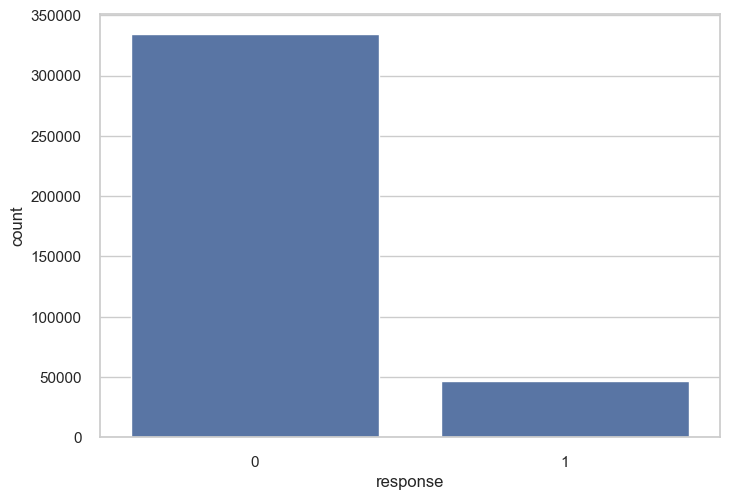

In [68]:
aux = df4['response']
sns.countplot(x=aux)
plt.show()

##### H1 - Younger customers may be more likely to purchase car insurance due to a higher probability of buying their first car or being interested in newer models that require insurance. (F)

We can see that younger people are not interested in car insurance, instead, midle age are more likely to hire the insurance

In [14]:
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']


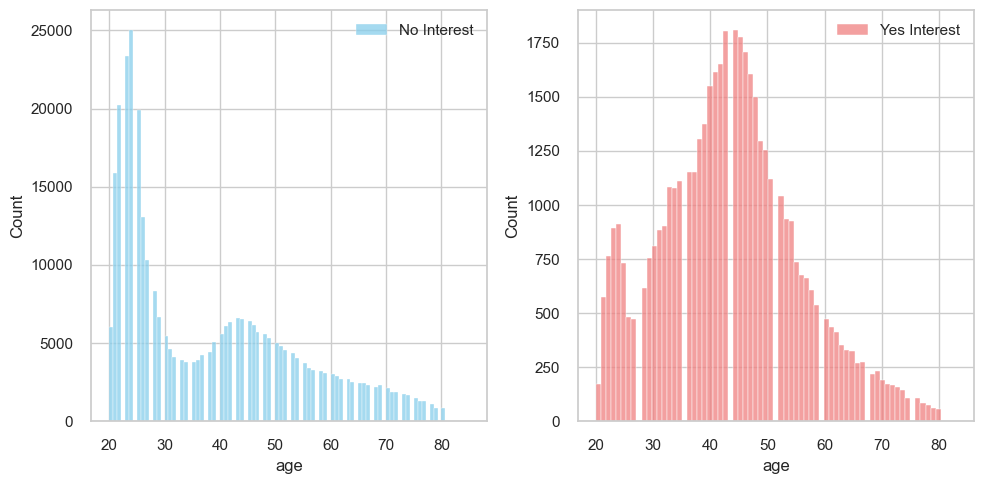

In [15]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(aux00, ax=axes[0], color='skyblue', label='No Interest')
sns.histplot(aux01, ax=axes[1], color='lightcoral', label='Yes Interest')

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

##### H2 - Men may show greater interest in car insurance compared to women, possibly due to a cultural association with driving. (T)

Apparently, men tend to purchase car insurance; among those who did, 61% were men.

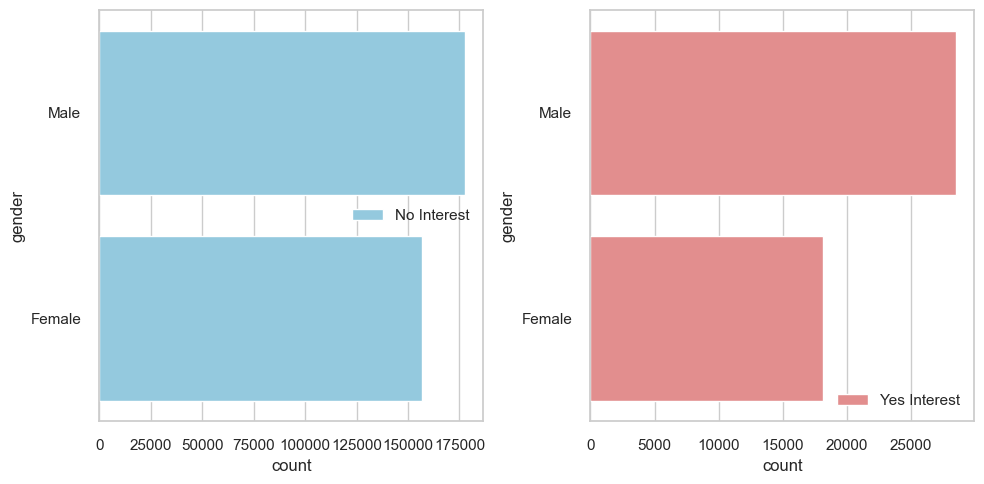

In [16]:
aux00 = df4.loc[df4['response'] == 0, 'gender']
aux01 = df4.loc[df4['response'] == 1, 'gender']

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(aux00, ax=axes[0], color='skyblue', label='No Interest')
sns.countplot(aux01, ax=axes[1], color='lightcoral', label='Yes Interest')

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

In [17]:
round(len(df4[(df4['response'] == 1) & (df4['gender'] == 'Male')]) / len(df4[df4['response'] == 1]) * 100,2)

61.07

In [18]:
round(len(df4[(df4['response'] == 1) & (df4['gender'] == 'Female')]) / len(df4[df4['response'] == 1]) * 100,2)

38.93

##### H3 -  Customers in urban areas or with higher population density may be more prone to purchasing car insurance due to the greater need for transportation and increased risk of accidents. ( - )

We can't know for sure if it's an urban, rural, or major city area. What we can do is see if the regions affect the decision to have or not have car insurance, and with this information, there's no much that we can analise, apparently, region 28 has a great number of insured, but, it can be an outlier.

<Axes: xlabel='region_code', ylabel='Count'>

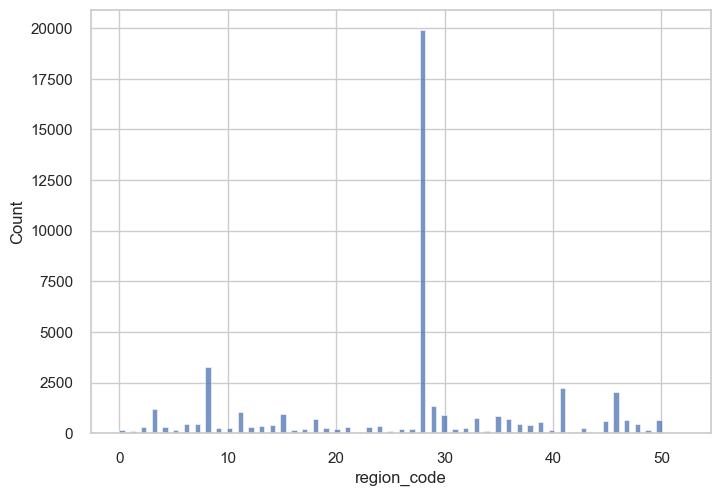

In [19]:
aux00 = df4[df4['response'] == 1]['region_code']
sns.histplot(aux00)

##### H4 - Customers who already have an car insurance  are more likely to decline this offer (T)

That's kind obvious, but it is best to make sure, as we can see, who has as insurance, has a NO responde in 99% of the time

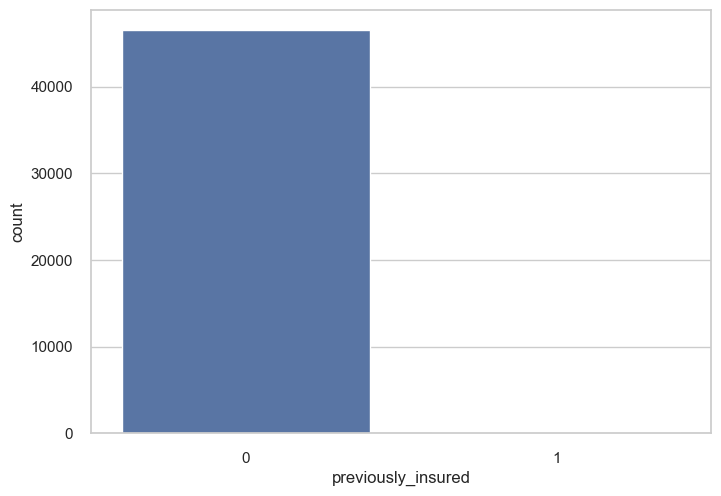

In [20]:
aux = df4.loc[df4['response'] == 1, 'previously_insured']

sns.countplot(x=aux)
plt.show()



##### H5 - If the vehicle has been damaged, then the vehicle insurance interest is greater. (T)

It seems that if a person has already had their vehicle in an accident, they are more likely to purchase car insurance. 


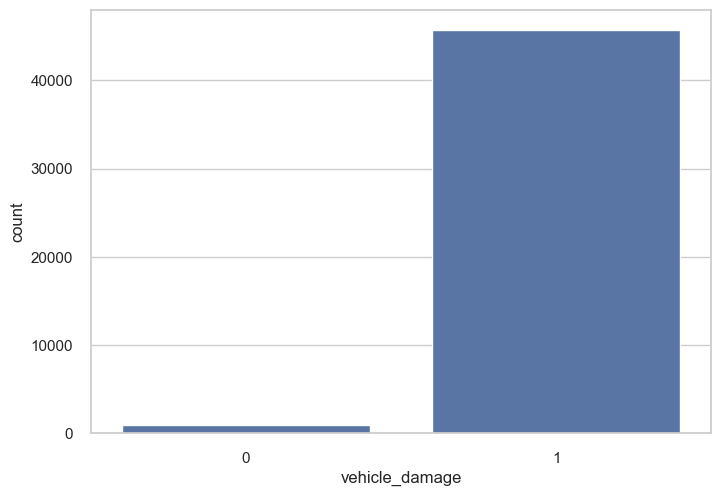

In [21]:
aux = df4.loc[df4['response'] == 1, 'vehicle_damage']
sns.countplot(x=aux)
plt.show()

##### H6 - Customers with older vehicle have less interest on vehicle insurance. (F)

Customers with older vehicle have more interest on vehicle insurance. This is curious too, people with less vehicle age tend to preserve their vehicles earlier, but that's not the case.

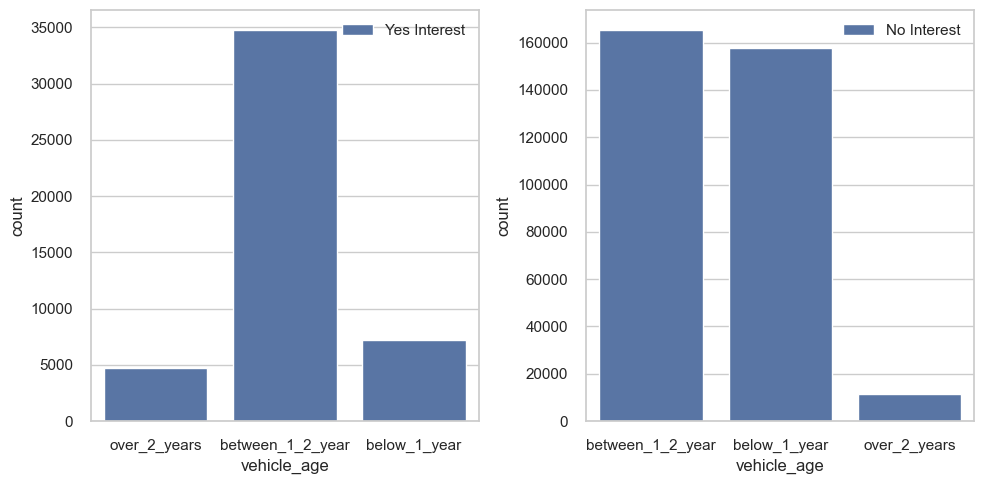

In [22]:
aux = df4.loc[df4['response'] == 1, 'vehicle_age']
aux1 = df4.loc[df4['response'] == 0, 'vehicle_age']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x=aux, ax=axes[0], label='Yes Interest')
sns.countplot(x=aux1, ax=axes[1], label='No Interest')

plt.tight_layout()
plt.show()


## 5.0 - PyCaret and AutoML

Machine learning projects can be quite complex, demanding intense focus, attention to detail, and above all, time.  We need to know how to properly handle our data, choose and train models, evaluate results, and all of this is time-consuming and prone to errors.

With this in mind, we'll be using the **PyCaret** AutoML framework.

<p align="center"><img src="https://pycaret.org/wp-content/uploads/2020/03/Divi93_43.png" width="60%"></p>

PyCaret is an open-source, low-code Python library that aims to reduce the cycle time between hypothesis and insights in machine learning experiments.

PyCaret enables data scientists to efficiently and quickly complete end-to-end experiments. Compared to other libraries, PyCaret differentiates itself by being low-code, meaning it requires minimal code for robust operation. All operations performed with PyCaret are loaded into a pipeline that is ready for deployment. Essentially, PyCaret is a low-code package that encompasses various machine learning libraries and frameworks like scikit-learn, XGBoost, Microsoft LightGBM, spaCy, and many more.


Before we choose the model, we need to know what type of problem it is, in order to facilitate the type of model to be chosen. In this case, it is a classification problem because we need to identify which customers have the potential to purchase insurance. After that, we will rank the customers in the Class buyers by probability of purchase. This helps to prioritize contacts, focusing on customers likely to purchase insurance.

### 5.1 - Spliting Data

Here's why splitting data before analysis using PyCaret is important:

* Generalization: Splitting data helps to assess a model's capability to generalize to unseen data, preventing overfitting (where the model performs well on training data but poorly on new data).

* Performance Estimation: A separate test set provides an unbiased estimate of a model's performance on new, unseen data. It simulates how the model might perform in real-world scenarios.

* Hyperparameter Tuning: Splitting allows for hyperparameter tuning on a validation set, optimizing the model's performance without introducing bias from the test set.

* Data Leakage Prevention: Splitting prevents data leakage, where information from the test set inadvertently influences the training process, leading to overly optimistic performance estimates.

* Model Selection: Splitting enables the comparison of different models on the same test set, facilitating a fair evaluation and selection of the best-performing model.

In [23]:
train = df4.sample(frac=0.2)
test = df4.drop(train.index)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### 5.2 - Setup
This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function in PyCaret. It only has two required parameters i.e. `data` and `target`. All the other parameters are optional.

In [24]:
s = setup(train, target = 'response',normalize=True ,session_id = 123)

,Description,Value
0,Session id,123
1,Target,response
2,Target type,Binary
3,Original data shape,"(76222, 12)"
4,Transformed data shape,"(76222, 14)"
5,Transformed train set shape,"(53355, 14)"
6,Transformed test set shape,"(22867, 14)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


Once the setup has been successfully executed it shows the information grid containing experiment level information. 

- **Session id:**  A pseudo-random number distributed as a seed in all functions for later reproducibility. If no `session_id` is passed, a random number is automatically generated that is distributed to all functions.<br/>
<br/>
- **Target type:**  Binary, Multiclass, or Regression. The Target type is automatically detected. <br/>
<br/>
- **Label Encoding:**  When the Target variable is of type string (i.e. 'Yes' or 'No') instead of 1 or 0, it automatically encodes the label into 1 and 0 and displays the mapping (0 : No, 1 : Yes) for reference. In this tutorial, no label encoding is required since the target variable is of numeric type. <br/>
<br/>
- **Original data shape:**  Shape of the original data prior to any transformations. <br/>
<br/>
- **Transformed train set shape :**  Shape of transformed train set <br/>
<br/>
- **Transformed test set shape :**  Shape of transformed test set <br/>
<br/>
- **Numeric features :**  The number of features considered as numerical. <br/>
<br/>
- **Categorical features :**  The number of features considered as categorical. <br/>

### 5.3 - Compare Models

This function trains and evaluates the performance of all the estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [25]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8776,0.8371,0.0003,0.2000,0.0006,0.0004,0.0053,0.2750
svm,SVM - Linear Kernel,0.8776,0.7978,0.0000,0.0000,0.0000,0.0000,0.0000,0.0400
ridge,Ridge Classifier,0.8776,0.8344,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310
dummy,Dummy Classifier,0.8776,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310
gbc,Gradient Boosting Classifier,0.8775,0.8545,0.0026,0.3983,0.0052,0.0037,0.0240,0.6350
ada,Ada Boost Classifier,0.8772,0.8501,0.0020,0.3411,0.0039,0.0022,0.0153,0.1660
lda,Linear Discriminant Analysis,0.8770,0.8344,0.0025,0.2560,0.0048,0.0024,0.0130,0.0350
lightgbm,Light Gradient Boosting Machine,0.8765,0.8517,0.0139,0.3679,0.0268,0.0182,0.0511,0.4640
rf,Random Forest Classifier,0.8723,0.8382,0.0689,0.3797,0.1165,0.0821,0.1182,0.4740
et,Extra Trees Classifier,0.8709,0.8338,0.0807,0.3739,0.1326,0.0932,0.1263,0.2790


The AUC, or Area Under the ROC Curve, is a valuable metric used to assess the performance of binary classification models. It quantifies the overall ability of a model to discriminate between positive and negative classes.

Here's a breakdown of the AUC and its relationship to the ROC curve:

**ROC Curve (Receiver Operating Characteristic Curve)**

* The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
* It plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
* The TPR is the proportion of actual positive samples that are correctly identified.
* The FPR is the proportion of actual negative samples that are incorrectly identified.

**AUC (Area Under the ROC Curve)**

* The AUC is a summary measure of the model's performance, calculated as the area under the ROC curve.
* It ranges from 0 to 1, with 1 indicating perfect classification and 0.5 indicating random chance.
* A higher AUC value indicates better discrimination ability of the model.

**Relationship Between ROC Curve and AUC**

* The AUC summarizes the ROC curve into a single scalar value, making it easier to compare different models.
* It represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.
* The ROC curve provides a visual representation of the model's performance at different thresholds, while the AUC provides an overall measure of the model's discriminatory power.

**Advantages of AUC**

* Threshold independence: The AUC evaluates the model's performance across all thresholds, making it robust for comparing models with different probability distributions.
* Interpretability: The AUC represents the probability that the model will correctly rank a random positive sample higher than a random negative sample.
* Application to imbalanced classes: The AUC is useful even when dealing with imbalanced datasets, as it considers the ability of the model to classify both classes correctly.

In essence, the AUC provides a way to quantify the overall performance of a binary classification model as represented by the ROC curve. It is a valuable metric for comparing different models and assessing their ability to accurately discriminate between classes.

I am going to choose `Gradient Bosting Classifier` because it's seems to give a better AUC score, anda a decent Accuracy

### 5.4 - Instantiating the Model

While `compare_models()` is a powerful function, and usually an excellent starting point, it does not return trained models. The workflow recommended by PyCaret is to use `compare_models` right after setup to evaluate which models perform best with the dataset and select a few candidates to continue experimenting with.

Therefore, the function allows you to create models from the `create_model()` function. This function creates the model and evaluates it using stratified cross-validation.

For this specific dataset, we'll focus on just one model, the ***Gradient Boosting Classifier***, or GBR, to keep things simple.

In [26]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8774,0.8606,0.0031,0.4000,0.0061,0.0042,0.0259
1,0.8774,0.8553,0.0031,0.4000,0.0061,0.0042,0.0259
2,0.8771,0.8422,0.0015,0.2000,0.0030,0.0012,0.0073
3,0.8774,0.8575,0.0015,0.3333,0.0030,0.0019,0.0153
4,0.8778,0.8518,0.0046,0.6000,0.0091,0.0073,0.0446
5,0.8772,0.8611,0.0015,0.2500,0.0030,0.0016,0.0107
6,0.8772,0.8564,0.0000,0.0000,0.0000,-0.0007,-0.0072
7,0.8778,0.8598,0.0031,0.6667,0.0061,0.0050,0.0394
8,0.8782,0.8586,0.0061,0.8000,0.0122,0.0103,0.0633


### 5.5 -Tuning the Model

When a model is created using `create_model()`, it uses the default hyperparameters for each model. To tune these hyperparameters, we use the `tune_model()` function.

This function automatically tunes the hyperparameters and, once again, evaluates the model using cross-validation.

In [27]:
tuned_gbc = tune_model(gbc, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8776,0.8612,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8776,0.8527,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8776,0.8391,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8774,0.8560,0.0000,0.0000,0.0000,-0.0004,-0.0051
4,0.8776,0.8536,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8776,0.8585,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8776,0.8533,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8776,0.8583,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8776,0.8558,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


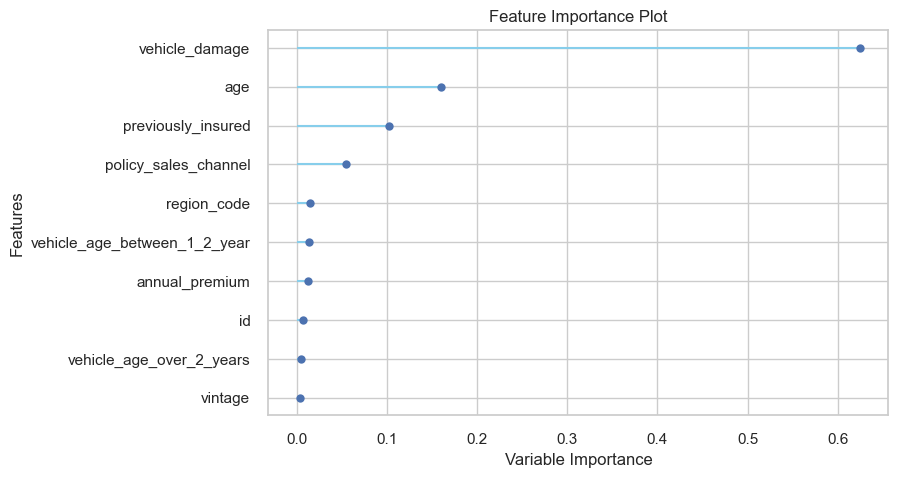

In [28]:
plot_model(tuned_gbc, plot='feature')

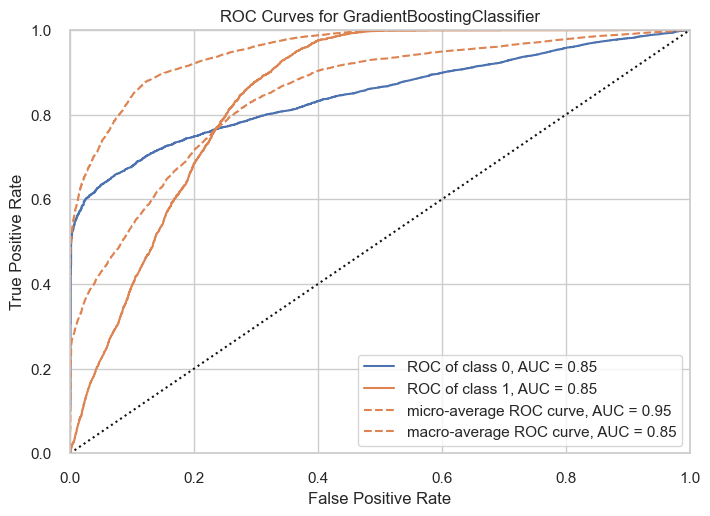

In [29]:
plot_model(tuned_gbc, plot = 'auc')

This graph displays the **ROC (Receiver Operating Characteristic) curves** for a Gradient Boosting classifier. ROC curves are a crucial tool for evaluating the performance of binary classification models, and in this case, it appears you have a problem with two classes (0 and 1).

**Let's understand the key elements:**

* **X-axis (False Positive Rate):** Represents the rate of false positives, i.e., the proportion of negative examples that were incorrectly classified as positive.
* **Y-axis (True Positive Rate):** Represents the rate of true positives, i.e., the proportion of positive examples that were correctly classified.
* **ROC Curves:** Each curve in the graph represents the classifier's performance for a different decision threshold. A decision threshold defines the cutoff point for classifying an example as positive or negative. By varying this threshold, we obtain different points on the ROC curve.
* **AUC (Area Under the Curve):** The area under the ROC curve is a metric that summarizes the overall performance of the classifier. The higher the AUC, the better the model is at distinguishing between the classes. An AUC of 0.5 indicates a random classifier, while an AUC of 1.0 represents a perfect classifier.

**Interpreting the curves:**

* **ROC of class 0, AUC = 0.86:** This curve shows the classifier's performance in identifying class 0. The AUC of 0.86 indicates good performance in distinguishing between class 0 and class 1.
* **ROC of class 1, AUC = 0.86:** Similarly, this curve shows the performance for class 1, also with a good AUC of 0.86.
* **micro-average ROC curve, AUC = 0.95:** This curve represents the weighted average of the individual ROC curves, considering the number of examples in each class. The AUC of 0.95 indicates excellent overall performance of the classifier.
* **macro-average ROC curve, AUC = 0.86:** This curve represents the simple average of the individual ROC curves, without considering the number of examples in each class.

**In summary:**

The graph indicates that the Gradient Boosting classifier performs well in the classification task, with a high capacity to distinguish between the two classes. The different ROC curves and AUCs provide a detailed view of the model's performance in different scenarios and for each class.


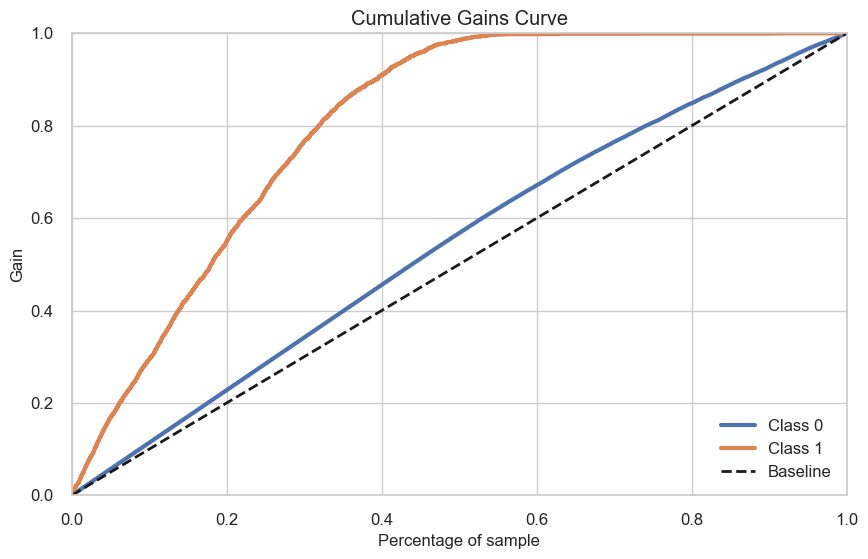

In [30]:
plot_model(tuned_gbc, plot = 'gain')

This graph shows a **Cumulative Gains Curve**. It helps you see how much better your model is at finding positive cases ("responders") compared to just random guessing.

**Here's the gist:**

* **X-axis:**  The percentage of your total data, sorted by how likely your model thinks they'll respond (highest to lowest).
* **Y-axis:**  The percentage of *all* positive cases you've found so far in that portion of your data.
* **Higher curve = better:**  The higher your curve is above the diagonal line, the better your model is at finding responders early on.
* **Example:** If your curve hits 80% gain at 20% of the data, it means your model found 80% of the responders by targeting just the top 20% most likely ones.

This is super useful for things like marketing, where you want to find the people most likely to buy your product without wasting effort on everyone.


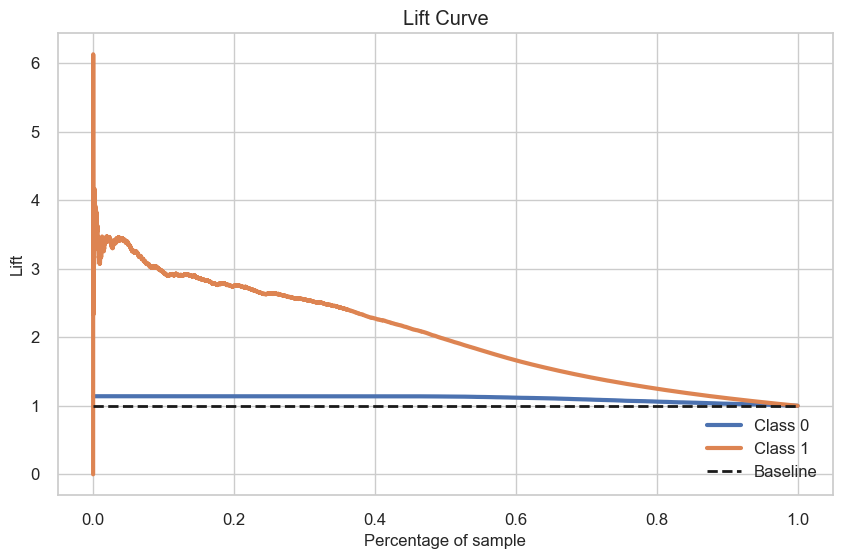

In [31]:
plot_model(tuned_gbc, plot = 'lift')

### 5.6 - Making Predictions

Before finalizing the model, it is recommended that you do a final check by making predictions on the test set and reviewing the evaluation metrics.

The goal here is to check the difference in performance between the results of cross-validation and the new data.


In [32]:
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8775,0.8462,0.0036,0.4167,0.0071,0.0050,0.0291


### 5.7 - Finalizing the Model

Finalizing the model is the last step in our project. A normal workflow in PyCaret starts with `setup()`, followed by `compare_models()` to find the best candidates based on the evaluation metrics of interest, and then proceed with parameter tuning, ensembling, stacking, etc.

This workflow will eventually lead you to the best model for making predictions on unseen data. The function `finalize_model()` fits the model, including the test set previously separated within PyCaret (30% in this case).

The purpose of this is to train the model on the complete dataset before deploying it to production.


In [33]:
final_gbc = finalize_model(tuned_gbc)

A Word of Caution

Once the model is finalized using the `finalize_model()` function, the entire dataset, including the portion that was previously separated for testing, is used for training.

Therefore, if the model is used to make predictions on the test set separated by PyCaret after the finalize function has been used, the results will be misleading, as you will be making predictions on data already seen by the model.

To demonstrate this, I will use the finalized model with `predict_model()` to compare the results with those we had in the previous part.


In [34]:
predict_model(final_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8778,0.8529,0.0021,0.6667,0.0043,0.0035,0.0330


Look the precision, it's increased significantly. But don't worry, lets continue...

In [35]:
print(final_gbc)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['id', 'age', 'driving_license',
                                             'region_code',
                                             'previously_insured',
                                             'vehicle_damage', 'annual_premium',
                                             'policy_sales_channel',
                                             'vintage'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_value...
                                            criterion='frie

### 5.8 - Predicting on New Data

The `predict_model()` function is also used to predict on datasets never seen before. The only difference is that for this we will pass the `data` parameter.

In this way, we will pass as `data` the data that has not yet been seen by the model, separated previously, at the beginning of the project.

This set contains 20% of the original dataset. This portion has never been exposed to PyCaret, and is perfect for simulating real new data that will be received by the model in production.


In [36]:
unseen_predictions = predict_model(final_gbc, data=test)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8774,0.8553,0.0010,0.4699,0.0021,0.0015,0.0175


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction_label,prediction_score
0,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0,0,0.9140
1,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1,1,0.6984
2,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0,0,0.9928
3,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0,0,0.9933
4,6,Female,24,1,33.0,0,below_1_year,1,2630.0,160.0,176,0,0,0.6822


### 5.9 - Saving the Model

Now that we have finished our work with the model, it's time to worry about how to keep it usable and ready to make new predictions on new data.

With the `save_model()` function we are able to save our trained model, ready for use. Inside it is also contained the entire preprocessing pipeline that was used. Just pass the dataset to make the predictions.


In [37]:
save_model(final_gbc,'Modelo_Final_19_11_2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['id', 'age', 'driving_license',
                                              'region_code',
                                              'previously_insured',
                                              'vehicle_damage', 'annual_premium',
                                              'policy_sales_channel',
                                              'vintage'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_value...
                                             

In [53]:
n_predictions = predict_model(final_gbc, data=df4)
n_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8775,0.8560,0.0012,0.5472,0.0025,0.0019,0.0216


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction_label,prediction_score
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1,1,0.6889
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0,0,0.9140
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1,1,0.6984
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0,0,0.9928
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0,0,0.9933
